In [2]:
import os, sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy as sa
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import timedelta, date


In [3]:
def query_arc_alchemy(sql):
    # ODBC connection string
    _url ='mssql+pyodbc:///?odbc_connect=DATABASE%3DMarketData%3BDRIVER%3D%7BSQL+Server+Native+Client+11.0%7D%3BSERVER%3DFOTDAL02PR%3BTrace%3D0%3BTrusted_Connection%3DYes'
 

    engine =sa.create_engine(_url, echo=False, convert_unicode=True)
    with engine.connect() as connection:
        result =connection.execute(sql)
        data =result.fetchall()
        column_names =result.keys()
        dataframe = pd.DataFrame.from_records(data, columns=column_names)

        return dataframe

query_str_1 = f"""
SELECT               
b.[DateDestination] as [PointDate_Destination] 
,b.[DateOrigin]        
,b.[Origin]
,b.[VolumeOriginM3] *(0.452839/1000000)*1346 as LoadedVolume
,a. [Name]          
,b.[Destination] 
,b.[CountryOrigin]          
,b.[CountryDestination]     
,b.[TradeStatus]  	           
,b.[VolumeDestinationM3]*(0.452839/1000000)*1346 as VolumeDestinationMcm
,b.[VolumeDestinationM3]*0.452839/1000000 as VolumeDestinationMt
,b.[SubcontinentDestination]
,b.[SubcontinentOrigin]

FROM                   


( SELECT [KplerVesselId]                               
,[Name]                         
 FROM [MarketData].[Gas].[KplerVessel])a           
  INNER JOIN                     
  (SELECT [DateDestination]        
  ,[DateOrigin] 	          
  ,[Origin]                
  ,[KplerVesselId]  	          
  ,[Destination]                
  ,[VolumeOriginM3]  	          
  ,[VolumeDestinationM3]          
  ,[CountryOrigin]          
  ,[CountryDestination]          
  ,[TradeStatus]
  ,[SubcontinentDestination]
  ,[SubcontinentOrigin]
  FROM [MarketData].[Gas].[KplerTrade])b           
   ON a.[KplerVesselId]= b.[KplerVesselId]           
   WHERE TradeStatus in ('Delivered', 'In Transit')           

ORDER BY  [DateOrigin] desc

"""


### Extract Dataframe

In [4]:
kpler = query_arc_alchemy(query_str_1)

In [5]:
kpler.shape

(60290, 13)

In [6]:
today =  np. datetime64(date.today()); today

numpy.datetime64('2021-06-30')

In [7]:
kpler.dtypes

PointDate_Destination      datetime64[ns]
DateOrigin                 datetime64[ns]
Origin                             object
LoadedVolume                       object
Name                               object
Destination                        object
CountryOrigin                      object
CountryDestination                 object
TradeStatus                        object
VolumeDestinationMcm               object
VolumeDestinationMt                object
SubcontinentDestination            object
SubcontinentOrigin                 object
dtype: object

### Reduce Dataframe to only include vessels that have discharged

In [8]:
kpler = kpler[kpler['PointDate_Destination']<=today]

In [9]:
kpler.shape

(60034, 13)

In [10]:
kpler.head()

PointDate_Destination          DateOrigin            Origin  \
34   2021-06-29 13:47:00 2021-06-28 12:01:00          Ishikari   
48   2021-06-28 20:42:00 2021-06-27 19:59:00           Vysotsk   
53   2021-06-29 11:15:00 2021-06-27 13:37:00          Bethioua   
60   2021-06-28 03:01:00 2021-06-27 06:41:00  PipeChina Yangpu   
73   2021-06-29 06:30:00 2021-06-26 06:29:00         Stavanger   

       LoadedVolume                  Name              Destination  \
34   1.801135423770           Kakuyu Maru                Akita LNG   
48  10.806812542620        Coral Energice                Nynashamn   
53  33.629727875156         Global Energy               Fos Tonkin   
60  18.011354237700  Hai Yang Shi You 301  PipeChina Fangchenggang   
73   2.261933522034                Kairos                Nynashamn   

         CountryOrigin CountryDestination TradeStatus VolumeDestinationMcm  \
34               Japan              Japan  In Transit       1.798697338594   
48  Russian Federation             Sweden   Delivered      10.790355467682   
53             Algeria             France   Delivered      33.579137607754   
60               China              China   Delivered      18.011354237700   
73              Norway             Sweden  In Transit       2.251571660036   

    VolumeDestinationMt SubcontinentDestination SubcontinentOrigin  
34  0.00133632788900000            Eastern Asia       Eastern Asia  
48  0.00801660881700000         Northern Europe               None  
53  0.02494735334900000          Western Europe    Northern Africa  
60  0.01338139245000000            Eastern Asia       Eastern Asia  
73  0.00167278726600000         Northern Europe    Northern Europe

# Exports groupings

In [11]:
Exports = kpler[['PointDate_Destination','CountryOrigin','Origin','CountryDestination','SubcontinentDestination','VolumeDestinationMcm']].copy()

In [12]:
Exports_Grouping = Exports.groupby(['CountryOrigin','Origin','SubcontinentDestination','CountryDestination',pd.Grouper(key='PointDate_Destination',freq='M')])[['VolumeDestinationMcm']].sum()


In [13]:
Exports_Grouping.tail()

VolumeDestinationMcm
CountryOrigin Origin SubcontinentDestination CountryDestination PointDate_Destination                     
Yemen         Balhaf West Europe             Belgium            2011-11-30                 90.700425674964
                                             France             2011-07-31                 88.960242380594
                                                                2013-06-30                 93.646242088866
                     Western Europe          France             2010-11-30                 97.491711932712
                                                                2011-05-31                 80.773152359586

In [14]:
Exports_pivot = pd.pivot_table(Exports_Grouping,index='PointDate_Destination',columns =['CountryOrigin','Origin','SubcontinentDestination','CountryDestination'],values ='VolumeDestinationMcm' ,aggfunc = np.sum)

In [15]:
Exports_pivot.fillna(0,inplace=True)

In [16]:
Exports_pivot.tail()

CountryOrigin                                                         \
Origin                      Gibraltar Gulf of Guinea                   
SubcontinentDestination South America                Southern Europe   
CountryDestination          Argentina                       Portugal   
PointDate_Destination                                                  
2021-02-28                          0              0               0   
2021-03-31                          0              0               0   
2021-04-30                          0              0               0   
2021-05-31                          0              0               0   
2021-06-30                          0              0               0   

CountryOrigin                                           Algeria  \
Origin                  Malacca Strait                 Bethioua   
SubcontinentDestination   Eastern Asia        Caribbean Islands   
CountryDestination               China Japan Dominican Republic   
PointDate_Destination                                             
2021-02-28                           0     0                  0   
2021-03-31                           0     0                  0   
2021-04-30                           0     0                  0   
2021-05-31                           0     0                  0   
2021-06-30                           0     0                  0   

CountryOrigin                                                      ...  \
Origin                                                             ...   
SubcontinentDestination     Eastern Asia                           ...   
CountryDestination                 China Japan South Korea Taiwan  ...   
PointDate_Destination                                              ...   
2021-02-28                             0     0           0      0  ...   
2021-03-31               83.870739575694     0           0      0  ...   
2021-04-30               92.838626374316     0           0      0  ...   
2021-05-31               66.840105100040     0           0      0  ...   
2021-06-30                             0     0           0      0  ...   

CountryOrigin              Yemen                                            \
Origin                    Balhaf                                             
SubcontinentDestination  SE Asia          South America South-Central Asia   
CountryDestination      Malaysia Thailand         Chile              India   
PointDate_Destination                                                        
2021-02-28                     0        0             0                  0   
2021-03-31                     0        0             0                  0   
2021-04-30                     0        0             0                  0   
2021-05-31                     0        0             0                  0   
2021-06-30                     0        0             0                  0   

CountryOrigin                                                                 \
Origin                                                                         
SubcontinentDestination South-East Asia          Southern Europe West Europe   
CountryDestination             Malaysia Thailand           Spain     Belgium   
PointDate_Destination                                                          
2021-02-28                            0        0               0           0   
2021-03-31                            0        0               0           0   
2021-04-30                            0        0               0           0   
2021-05-31                            0        0               0           0   
2021-06-30                            0        0               0           0   

CountryOrigin                                  
Origin                                         
SubcontinentDestination        Western Europe  
CountryDestination      France         France  
PointDate_Destination                          
2021-02-28                   0              0

## Store list of column headers as seperate lists

In [17]:
list_CountryOrigin = Exports_pivot.columns.get_level_values(0).unique()
list_loadport = Exports_pivot.columns.get_level_values(1).unique()
list_deliveredregion = Exports_pivot.columns.get_level_values(2).unique()
list_countrydestination = Exports_pivot.columns.get_level_values(3).unique()

In [18]:
list_CountryOrigin

Index(['', 'Algeria', 'Angola', 'Argentina', 'Australia', 'Belgium', 'Brazil',
       'Brunei', 'Cameroon', 'China', 'Croatia', 'Cyprus',
       'Dominican Republic', 'Egypt', 'Equatorial Guinea', 'Finland', 'France',
       'India', 'Indonesia', 'Israel', 'Jamaica', 'Japan', 'Jordan',
       'Lithuania', 'Malaysia', 'Netherlands', 'Nigeria', 'Norway', 'Oman',
       'Papua New Guinea', 'Peru', 'Portugal', 'Puerto Rico', 'Qatar',
       'Russian Federation', 'Singapore Republic', 'South Korea', 'Spain',
       'Sweden', 'Thailand', 'Trinidad and Tobago', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Yemen'],
      dtype='object', name='CountryOrigin')

In [19]:
Exports_pivot.columns.get_level_values(3).unique()

Index(['Argentina', '', 'Portugal', 'China', 'Japan', 'Dominican Republic',
       'South Korea', 'Taiwan', 'Turkey', 'Egypt', 'Jordan', 'Kuwait',
       'United Arab Emirates', 'Mexico', 'United Kingdom', 'India', 'Greece',
       'Italy', 'Spain', 'Brazil', 'Chile', 'Bangladesh', 'Pakistan',
       'Malaysia', 'Singapore Republic', 'Thailand', 'France', 'Netherlands',
       'Belgium', 'Canada', 'Bahrain', 'Indonesia', 'Puerto Rico', 'Finland',
       'Norway', 'Sweden', 'Jamaica', 'Israel', 'Cyprus', 'United States',
       'Panama', 'Lithuania', 'Malta', 'Myanmar', 'Australia', 'Poland',
       'Croatia', 'Colombia'],
      dtype='object', name='CountryDestination')

In [20]:
country_buckets = {}

In [21]:
for country in list_CountryOrigin:
    country_buckets[country] = Exports_pivot[country]

In [22]:
country_buckets['United States']

Origin                     Cameron (Liqu.)                                     \
SubcontinentDestination  Caribbean Islands  Central America      Eastern Asia   
CountryDestination      Dominican Republic           Panama             China   
PointDate_Destination                                                           
2008-01-31                               0                0                 0   
2008-02-29                               0                0                 0   
2008-03-31                               0                0                 0   
2008-04-30                               0                0                 0   
2008-05-31                               0                0                 0   
...                                    ...              ...               ...   
2021-02-28                168.764865404014                0   89.148584460440   
2021-03-31                 92.171200557386  92.291885773598                 0   
2021-04-30                 90.545607266288                0                 0   
2021-05-31                184.225373026324                0  398.725059204334   
2021-06-30                 92.171200557386  92.054172468938   93.276262663408   

Origin                                                                         \
SubcontinentDestination                                                         
CountryDestination                  Japan       South Korea            Taiwan   
PointDate_Destination                                                           
2008-01-31                              0                 0                 0   
2008-02-29                              0                 0                 0   
2008-03-31                              0                 0                 0   
2008-04-30                              0                 0                 0   
2008-05-31                              0                 0                 0   
...                                   ...               ...               ...   
2021-02-28               570.813034703236  297.510391207870                 0   
2021-03-31               294.560308144910  100.061453708216                 0   
2021-04-30               200.530067640824  103.326659280174  106.548588840258   
2021-05-31               188.034271592530  100.389985685682  102.094816745000   
2021-06-30               199.924203474588                 0   90.415779230666   

Origin                                                                \
SubcontinentDestination Eastern Europe                   Middle East   
CountryDestination              Poland            Turkey      Kuwait   
PointDate_Destination                                                  
2008-01-31                           0                 0           0   
2008-02-29                           0                 0           0   
2008-03-31                           0                 0           0   
2008-04-30                           0                 0           0   
2008-05-31                           0                 0           0   
...                                ...               ...         ...   
2021-02-28                           0  265.537951731100           0   
2021-03-31                           0  104.265322072934           0   
2021-04-30                           0                 0           0   
2021-05-31                           0                 0           0   
2021-06-30                           0                 0           0   

Origin                                        ...       Sabine Pass  \
SubcontinentDestination                       ...    Western Europe   
CountryDestination      United Arab Emirates  ...            France   
PointDate_Destination                         ...                     
2008-01-31                                 0  ...                 0   
2008-02-29                                 0  ...                 0   
2008-03-31                                 0  ...            

# Import Groupings

In [23]:
Imports = kpler[['PointDate_Destination','CountryOrigin','Origin','CountryDestination','SubcontinentOrigin','VolumeDestinationMcm']].copy()

In [24]:
Imports_Grouping = Imports.groupby(['CountryDestination','SubcontinentOrigin','CountryOrigin','Origin',pd.Grouper(key='PointDate_Destination',freq='M')])[['VolumeDestinationMcm']].sum()

In [25]:
Imports_Grouping.head()

VolumeDestinationMcm
CountryDestination SubcontinentOrigin CountryOrigin Origin     PointDate_Destination                     
                   Middle East        Qatar         Ras Laffan 2014-01-31                127.999471740000
                   South-Central Asia India         Kochi      2015-10-31                 94.430086472950
                   Southern Europe    Cyprus        Limassol   2014-03-31                 30.103037668072
                                      Spain         Sagunto    2014-12-31                181.232623472784
                   West Asia          Yemen         Balhaf     2011-08-31                 89.799553202432

In [26]:
Imports_pivot = pd.pivot_table(Imports_Grouping,index='PointDate_Destination',columns =['CountryDestination','SubcontinentOrigin','CountryOrigin','Origin'],values ='VolumeDestinationMcm' ,aggfunc = np.sum)

In [27]:
Imports_pivot.fillna(0,inplace=True)

In [28]:
Imports_pivot.head()

CountryDestination                                                            \
SubcontinentOrigin    Middle East South-Central Asia Southern Europe           
CountryOrigin               Qatar              India          Cyprus   Spain   
Origin                 Ras Laffan              Kochi        Limassol Sagunto   
PointDate_Destination                                                          
2008-01-31                      0                  0               0       0   
2008-02-29                      0                  0               0       0   
2008-03-31                      0                  0               0       0   
2008-04-30                      0                  0               0       0   
2008-05-31                      0                  0               0       0   

CountryDestination                                             \
SubcontinentOrigin    West Asia Western Africa Western Europe   
CountryOrigin             Yemen        Nigeria         France   
Origin                   Balhaf          Bonny     Fos Cavaou   
PointDate_Destination                                           
2008-01-31                    0              0              0   
2008-02-29                    0              0              0   
2008-03-31                    0              0              0   
2008-04-30                    0              0              0   
2008-05-31                    0              0              0   

CountryDestination                    Argentina                      \
SubcontinentOrigin    Australia and New Zealand   Caribbean Islands   
CountryOrigin                         Australia Trinidad and Tobago   
Origin                                    APLNG        Atlantic LNG   
PointDate_Destination                                                 
2008-01-31                                    0                   0   
2008-02-29                                    0                   0   
2008-03-31                                    0                   0   
2008-04-30                                    0                   0   
2008-05-31                                    0                   0   

CountryDestination                                     ...   United States  \
SubcontinentOrigin    Latin America and the Caribbean  ... Northern Europe   
CountryOrigin                     Trinidad and Tobago  ...  United Kingdom   
Origin                                   Atlantic LNG  ...           Grain   
PointDate_Destination                                  ...                   
2008-01-31                                          0  ...               0   
2008-02-29                                          0  ...               0   
2008-03-31                                          0  ...               0   
2008-04-30                                          0  ...               0   
2008-05-31                                          0  ...               0   

CountryDestination                                                      \
SubcontinentOrigin    South America    South-East Asia Southern Europe   
CountryOrigin                  Peru Singapore Republic           Spain   
Origin                     Peru LNG               SLNG          Huelva   
PointDate_Destination                                                    
2008-01-31                        0                  0               0   
2008-02-29                        0                  0               0   
2008-03-31                        0                  0               0   
2008-04-30                        0                  0               0   
2008-05-31                        0                  0               0   

CountryDestination                                                     \
SubcontinentOrigin    West Africa  West Asia           Western Africa   
CountryOrigin             Nigeria      Qatar  Yemen Equatorial Guinea   
Origin                      Bonny Ras Laffan Balhaf             Bioko   
PointDate_Destination  

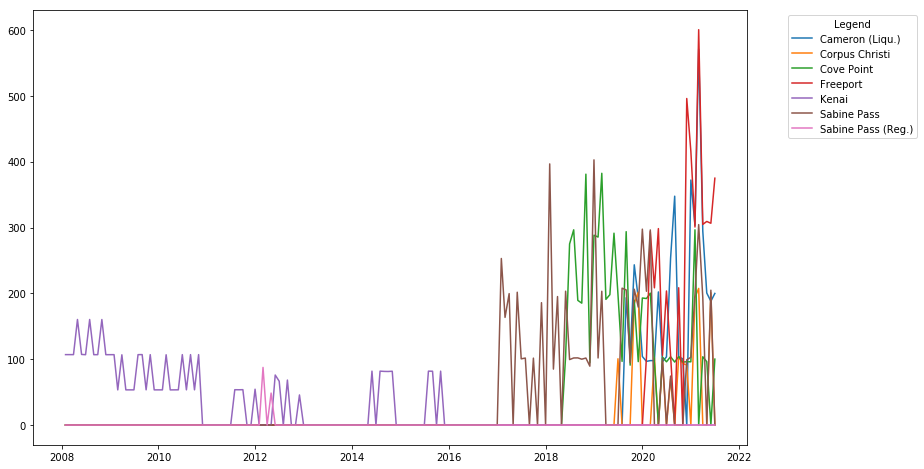

In [29]:
fig, ax = plt.subplots(figsize=(8*1.6, 8))
plt.plot(Imports_pivot['Japan']['Northern America']['United States'])
plt.legend(Imports_pivot['Japan']['Northern America']['United States'].columns, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

In [30]:
Imports_pivot['Japan']['Australia and New Zealand'].columns

MultiIndex([('Australia',      'APLNG'),
            ('Australia',    'Dampier'),
            ('Australia',     'Darwin'),
            ('Australia',       'GLNG'),
            ('Australia',     'Gorgon'),
            ('Australia',    'Ichthys'),
            ('Australia',        'NWS'),
            ('Australia',      'Pluto'),
            ('Australia',    'Prelude'),
            ('Australia',      'QCLNG'),
            ('Australia', 'Wheatstone')],
           names=['CountryOrigin', 'Origin'])

In [31]:
Import_CountryDestination = Imports_pivot.columns.get_level_values(0).unique()

In [32]:
country_imports = {}

## Write to Excel

In [33]:
file_name = 'Breakdown_Exports.xlsx'
with pd.ExcelWriter(file_name, engine='xlsxwriter', date_format='yyyy-mm-dd') as writer:
        Exports_pivot.to_excel(writer)

In [34]:
file_name = 'Breakdown_Exports_grouped.xlsx'
with pd.ExcelWriter(file_name, engine='xlsxwriter', date_format='yyyy-mm-dd') as writer:
    for country in list_CountryOrigin:
        country_buckets[country].to_excel(writer, sheet_name = country)